<a href="https://colab.research.google.com/github/Yagr49/Photocatalyst_NN/blob/Photocatal/notebooks/Validate_model_for_descriptors_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 15.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install xgboost

In [4]:
!pip install lightgbm

In [5]:
import xgboost
import lightgbm
import numpy as np
import pandas as pd
import catboost

In [6]:
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, cross_validate, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, balanced_accuracy_score, average_precision_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.kernel_ridge import KernelRidge
from sklearn.neural_network import MLPRegressor
import seaborn as sns
scores_mse_dict = {}
scores_mae_dict = {}
scores_pearson_dict = {}
rng = np.random.RandomState(42)
lin = LinearRegression()
from sklearn.ensemble import VotingRegressor
krr = KernelRidge(alpha=1.0, kernel='rbf')
krr_lin = KernelRidge()
dt = DecisionTreeRegressor(random_state=rng, max_depth=10, min_samples_leaf=10)
rf = RandomForestRegressor(n_estimators=50, random_state=rng)
knn = KNeighborsRegressor(n_neighbors=5, weights='distance')
cat = catboost.CatBoostRegressor(random_seed=42, task_type="GPU",
                           devices='0:1')
lgbm = lightgbm.LGBMRegressor(random_state=42)#,device='gpu')
lgbm_rf = lightgbm.LGBMRegressor(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=42)#,device='gpu')
xgb = xgboost.XGBRegressor(random_state=42,tree_method='hist',device='cuda')
xgb_rf = xgboost.XGBRFRegressor(random_state=42,tree_method='hist',device='cuda')
nb = GaussianNB()
voting_hard = VotingRegressor(estimators=[('lgbm', lgbm), ('catboost', cat), ('krr', krr), ('krr_lin', krr_lin)])
MLP = MLPRegressor(max_iter=500)
metrics=[]
model_name = []
#voting_soft = VotingRegressor(estimators=[('svr', svr_lin), ('nb', nb), ('dt', dt)])\
for model in [dt,  cat, knn,  xgb, lgbm,  xgb_rf, lgbm_rf, krr, voting_hard, MLP, krr_lin]:
    model_name.append(model.__class__.__name__)

In [7]:
model_name[6] = 'LGBMRegressor_RF'
model_name[7] = 'KernelRidge_rdf'
model_name[10] = 'KernelRidge_lin'
model_name

['DecisionTreeRegressor',
 'CatBoostRegressor',
 'KNeighborsRegressor',
 'XGBRegressor',
 'LGBMRegressor',
 'XGBRFRegressor',
 'LGBMRegressor_RF',
 'KernelRidge_rdf',
 'VotingRegressor',
 'MLPRegressor',
 'KernelRidge_lin']

#Download dataset

In [ ]:
start_db = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets/Organic_compound_final_dataset.csv.csv')
Chromophore = list(start_db['Chromophore'])

In [ ]:
change_nm = start_db['Absorption max (nm)']
change_nm_em = start_db['Emission max (nm)']
change_y = start_db['Quantum yield']

In [ ]:
morgan_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets//morgan_db.csv')
maccs_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets//maccs_db.csv')
tda_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets//tda_organic_compounds_db.csv')
SLATM_full = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets//SLATM_full.csv')
BOB_pca = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets//BOB_pca_full.csv')
CM_pca = pd.read_csv("/content/drive/MyDrive/MSU_AI_Photocatal/Datasets//CM_pca_db.csv")
CM_small = pd.read_csv('/content/drive/MyDrive/MSU_AI_Photocatal/Datasets//CM_small_db.csv')

In [ ]:
tda_db = pd.concat([tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
morgan_db = pd.concat([morgan_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
maccs_db = pd.concat([maccs_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
morgan_maccs_db = pd.concat([morgan_full,maccs_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
morgan_tda_db = pd.concat([morgan_full,tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
maccs_tda_db = pd.concat([maccs_full,tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_pca_db = pd.concat([CM_pca, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_pca_tda_db = pd.concat([CM_pca, tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_pca_morgan_db =  pd.concat([CM_pca, morgan_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_small_morgan_db = pd.concat([CM_small, morgan_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_small_maccs_db = pd.concat([CM_small, maccs_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_small_morgan_tda_db = pd.concat([CM_small, morgan_full, tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_small_maccs_tda_db = pd.concat([CM_small, maccs_full, tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_small_maccs_morgan_tda_db = pd.concat([CM_small, maccs_full,morgan_full, tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
BOB_pca_db = pd.concat([BOB_pca, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
BOB_pca_tda_db = pd.concat([BOB_pca, tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
BOB_pca_maccs_db =  pd.concat([BOB_pca, maccs_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_db = pd.concat([SLATM_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_tda_db = pd.concat([SLATM_full, tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_morgan_db = pd.concat([SLATM_full, morgan_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_maccs_db = pd.concat([SLATM_full, maccs_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_morgan_tda_db = pd.concat([SLATM_full, morgan_full, tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_maccs_tda_db = pd.concat([SLATM_full, maccs_full, tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_maccs_morgan_tda_db = pd.concat([SLATM_full, maccs_full,morgan_full, tda_full, pd.DataFrame({'Absorption':change_nm}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()

In [ ]:
list_of_dataset = [tda_db,morgan_db,maccs_db,morgan_maccs_db,
                   morgan_tda_db,maccs_tda_db,CM_pca_db,
                   CM_pca_tda_db, CM_pca_morgan_db, CM_small_morgan_db,
                   CM_small_maccs_db, CM_small_morgan_tda_db, CM_small_maccs_tda_db,
                   CM_small_maccs_morgan_tda_db, BOB_pca_db,BOB_pca_tda_db,
                   BOB_pca_maccs_db,SLATM_db,SLATM_tda_db,SLATM_morgan_db,
                   SLATM_maccs_db, SLATM_morgan_tda_db, SLATM_maccs_tda_db, SLATM_maccs_morgan_tda_db]

In [10]:
dict_df = {'tda':[],'morgan':[],'maccs':[],
           'morgan_maccs':[],'morgan_tda':[],'maccs_tda':[],
           'CM_pca':[],'CM_pca_tda':[],'CM_pca_morgan':[],
           'CM_small_morgan':[],'CM_small_maccs':[],'CM_small_morgan_tda':[],
           'CM_small_maccs_tda':[], 'CM_small_morgan_maccs_tda':[],
           'BOB_pca':[],'BOB_pca_tda':[],'BOB_pca_maccs':[],
           'SLATM':[], 'SLATM_tda':[],'SLATM_morgan':[],'SLATM_maccs':[],
           'SLATM_morgan_tda':[],'SLATM_maccs_tda':[],'SLATM_maccs_morgan_tda':[]}

In [ ]:
#{,'BOB_pca':[],'BOB_pca_tda':[],'BOB_pca_maccs':[],'SLATM_tda':[],'SLATM_morgan':[],'SLATM_maccs':[],'SLATM_morgan_tda':[],'SLATM_maccs_tda':[],'SLATM_maccs_morgan_tda':[]}

In [ ]:
model_name_2 = ['VotingRegressor',
 'MLPRegressor',
 'KernelRidge_lin']

In [16]:
zero = np.zeros((len(dict_df.keys()),len(model_name)))
result_df = pd.DataFrame(zero, columns = model_name, index = dict_df.keys())
result_df

,DecisionTreeRegressor,CatBoostRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor,XGBRFRegressor,LGBMRegressor_RF,KernelRidge_rdf,VotingRegressor,MLPRegressor,KernelRidge_lin
tda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
morgan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
maccs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
morgan_maccs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
morgan_tda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
maccs_tda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM_pca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM_pca_tda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM_pca_morgan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM_small_morgan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler
models = [voting_hard, MLP, krr_lin]
for i in tqdm(range(len(list_of_dataset))):
    x_train, x_test, y_train, y_test = train_test_split(list_of_dataset[i].loc[:, list_of_dataset[i].columns != 'Absorption'], list_of_dataset[i]['Absorption'], test_size=0.2, random_state=42, shuffle=True)
    x_train = x_train.fillna(0.0)
    scaler = StandardScaler()
    scaler.fit(x_train)
    #y_train = np.log(y_train)
    #y_test = np.log(y_test)
    x_train = pd.DataFrame(scaler.transform(x_train))
    x_test = pd.DataFrame(scaler.transform(x_test))
    print('Scalling finished')
    for j in range(len(models)):#dt,  cat, knn,  xgb, lgbm,  xgb_rf, krr, voting_hard, MLP, krr_lin]:
        scores = cross_val_score(models[j], x_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=rng), scoring='neg_root_mean_squared_error')
        scores_mse_dict[f'{model_name_2[j].__class__.__name__}'] = -1*scores.mean()
        result_df[f'{model_name_2[j]}'][f'{list(dict_df.keys())[i]}'] = -1*scores.mean()
        print(f'{model_name_2[j]} MSE: {-1*scores.mean()}')

In [32]:
result_df

,DecisionTreeRegressor,CatBoostRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor,XGBRFRegressor,LGBMRegressor_RF,KernelRidge_rdf,VotingRegressor,MLPRegressor,KernelRidge_lin
tda,71.912494,61.073543,68.333783,55.922770,61.857273,74.816875,73.908318,74.020012,126.764138,74.030467,437.208518
morgan,52.780068,37.511779,44.028277,32.812561,36.671290,57.832644,58.745252,113.812577,3941.163243,201.451192,15560.826066
maccs,49.050711,38.457020,45.922097,33.854415,39.542558,54.569204,58.997296,63.355756,5611.609046,49.643129,32914.571342
morgan_maccs,49.839791,34.551213,41.783476,31.220448,34.373192,53.880151,57.222241,111.989067,4019.908802,115.187635,16086.417497
morgan_tda,52.464718,37.380028,43.509422,33.371540,35.908309,57.448150,58.003574,112.233626,4035.982013,190.364413,16038.947223
maccs_tda,50.068886,38.266945,44.115862,34.339053,39.068495,54.598351,57.747800,62.397592,9110.313018,50.575796,25081.605381
CM_pca,73.326729,58.778877,63.781590,57.458253,59.117966,72.820199,73.712970,94.737379,4983.155744,85.748997,20019.573747
CM_pca_tda,69.412620,55.362393,60.496373,53.292465,55.668670,69.327559,69.227377,91.634818,5438.034235,80.710343,21258.506521
CM_pca_morgan,54.691806,37.827987,46.627220,36.993217,38.130393,57.790179,58.489474,108.016945,3848.621824,213.271471,14826.455451
CM_small_morgan,53.594725,37.688264,43.829717,34.204789,36.724521,57.736275,58.625902,111.640016,3875.620893,132.900594,16236.613150


In [ ]:
model_name_2 = ['DecisionTreeRegressor',
 'CatBoostRegressor',
 'KNeighborsRegressor',
 'XGBRegressor',
 'LGBMRegressor',
 'XGBRFRegressor',
 'LGBMRegressor_RF',
 'KernelRidge_rdf',
 'MLPRegressor']

In [25]:
Abs_result = result_df[model_name_2]

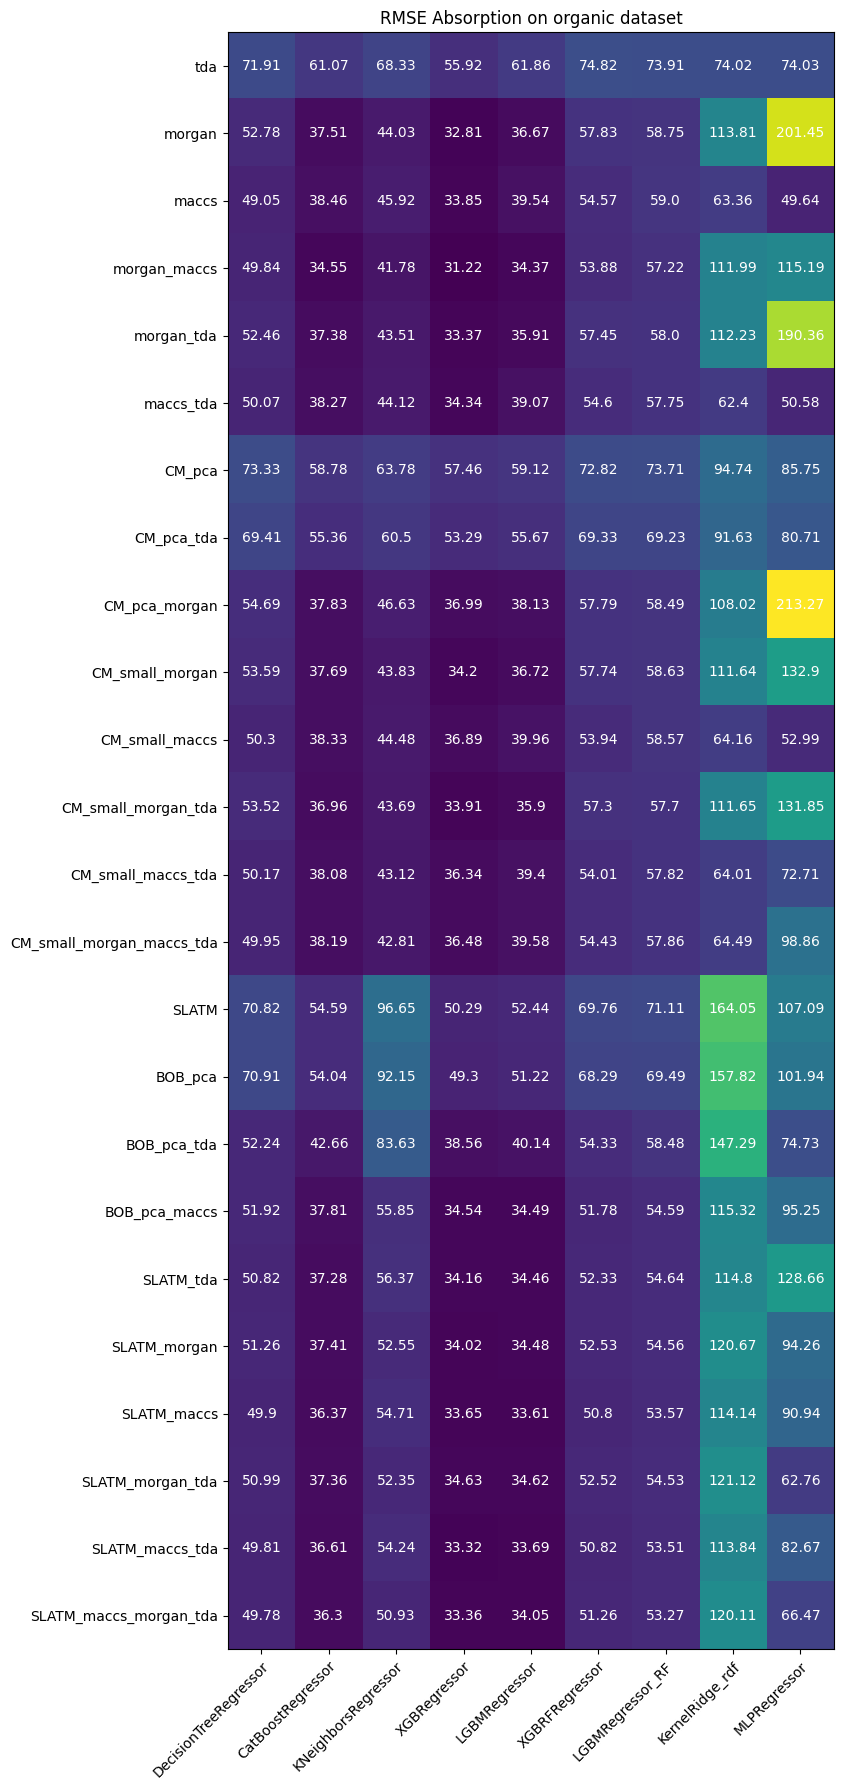

In [30]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(18, 18))
im = ax.imshow(Abs_result)
ax.set_xticks(np.arange(len(Abs_result.columns)), labels=Abs_result.columns)
ax.set_yticks(np.arange(len(Abs_result.index)), labels=Abs_result.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(Abs_result.index)):
    for j in range(len(Abs_result.columns)):
        text = ax.text(j, i, round(np.array(Abs_result)[i, j],2),
                       ha="center", va="center", color="w")
ax.set_title("RMSE Absorption on organic dataset")
fig.tight_layout()
plt.show()

# EMission

In [ ]:
tda_db_em = pd.concat([tda_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
morgan_db_em = pd.concat([morgan_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
maccs_db_em = pd.concat([maccs_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
morgan_maccs_db_em = pd.concat([morgan_full,maccs_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_pca_tda_db_em = pd.concat([CM_pca, tda_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_pca_morgan_db_em =  pd.concat([CM_pca, morgan_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_small_morgan_db_em = pd.concat([CM_small, morgan_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
CM_small_morgan_tda_db_em = pd.concat([CM_small, morgan_full, tda_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
BOB_pca_maccs_db_em =  pd.concat([BOB_pca, maccs_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_db_em = pd.concat([SLATM_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_tda_db_em = pd.concat([SLATM_full, tda_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_morgan_db_em = pd.concat([SLATM_full, morgan_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_maccs_db_em = pd.concat([SLATM_full, maccs_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_maccs_tda_db_em = pd.concat([SLATM_full, maccs_full, tda_full, pd.DataFrame({'Emission':change_nm_em}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()

In [ ]:
list_of_dataset_em = [tda_db_em, morgan_db_em, maccs_db_em, morgan_maccs_db_em, CM_pca_tda_db_em, CM_pca_morgan_db_em, CM_small_morgan_db_em, CM_small_morgan_tda_db_em, BOB_pca_maccs_db_em,  SLATM_db_em, SLATM_tda_db_em, SLATM_morgan_db_em, SLATM_maccs_db_em, SLATM_maccs_tda_db_em]

In [33]:
list_of_dataset_em_name= ['tda', 'morgan', 'maccs', 'morgan_maccs', 'CM_pca_tda', 'CM_pca_morgan', 'CM_small_morgan', 'CM_small_morgan_tda', 'BOB_pca_maccs', 'SLATM', 'SLATM_tda', 'SLATM_morgan', 'SLATM_maccs', 'SLATM_maccs_tda']

In [40]:
models = [dt,  cat, knn,  xgb, lgbm,  xgb_rf, lgbm_rf, krr, MLP]
model_name = ['DecisionTreeRegressor',
 'CatBoostRegressor',
 'KNeighborsRegressor',
 'XGBRegressor',
 'LGBMRegressor',
 'XGBRFRegressor',
 'LGBMRegressor_RF',
 'KernelRidge_rdf',
 'MLPRegressor']

In [41]:
zero = np.zeros((len(list_of_dataset_em_name),len(model_name)))
result_df_em = pd.DataFrame(zero, columns = model_name, index = list_of_dataset_em_name)
result_df_em

,DecisionTreeRegressor,CatBoostRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor,XGBRFRegressor,LGBMRegressor_RF,KernelRidge_rdf,MLPRegressor
tda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
morgan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
maccs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
morgan_maccs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM_pca_tda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM_pca_morgan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM_small_morgan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CM_small_morgan_tda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BOB_pca_maccs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SLATM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.preprocessing import StandardScaler



for i in range(len(list_of_dataset_em)):#len(list_of_dataset)):
    x_train, x_test, y_train, y_test = train_test_split(list_of_dataset_em[i].loc[:, list_of_dataset_em[i].columns != 'Emission'], list_of_dataset_em[i]['Emission'], test_size=0.2, random_state=42, shuffle=True)
    scaler = StandardScaler()
    x_train = x_train.fillna(0.0)
    scaler.fit(x_train)

    #y_train = np.log(y_train)
    #y_test = np.log(y_test)
    x_train = pd.DataFrame(scaler.transform(x_train))
    x_test = pd.DataFrame(scaler.transform(x_test))
    print('Scalling finished')
    for j in range(len(models)):#dt,  cat, knn,  xgb, lgbm,  xgb_rf, krr, voting_hard, MLP, krr_lin]:

        scores = cross_val_score(models[j], x_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=rng), scoring='neg_root_mean_squared_error')
        #scores_mse_dict[f'{model_name[j].__class__.__name__}'] = -1*scores.mean()
        result_df_em[f'{model_name[j]}'][f'{list(list_of_dataset_em_name)[i]}'] = -1*scores.mean()
        print(f'{model_name[j]} MSE: {-1*scores.mean()}')

Streaming output truncated to the last 5000 lines.
6:	learn: 78.3109848	total: 2.07s	remaining: 4m 54s
7:	learn: 77.1603795	total: 2.37s	remaining: 4m 53s
8:	learn: 76.1249613	total: 2.67s	remaining: 4m 54s
9:	learn: 74.9152912	total: 2.97s	remaining: 4m 53s
10:	learn: 73.9652094	total: 3.25s	remaining: 4m 52s
11:	learn: 73.0293811	total: 3.54s	remaining: 4m 51s
12:	learn: 72.1283070	total: 3.82s	remaining: 4m 50s
13:	learn: 71.2778001	total: 4.11s	remaining: 4m 49s
14:	learn: 70.4812536	total: 4.4s	remaining: 4m 48s
15:	learn: 69.7721654	total: 4.68s	remaining: 4m 47s
16:	learn: 69.0424658	total: 4.96s	remaining: 4m 46s
17:	learn: 68.3970376	total: 5.25s	remaining: 4m 46s
18:	learn: 67.8201801	total: 5.53s	remaining: 4m 45s
19:	learn: 67.2720128	total: 5.82s	remaining: 4m 45s
20:	learn: 66.6187192	total: 6.12s	remaining: 4m 45s
21:	learn: 66.1642720	total: 6.38s	remaining: 4m 43s
22:	learn: 65.7825387	total: 6.66s	remaining: 4m 42s
23:	learn: 65.3449156	total: 6.93s	remaining: 4m 41s


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [11:07:48] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Выходные данные были обрезаны до нескольких последних строк (5000).
92:	learn: 51.8494047	total: 26.1s	remaining: 4m 14s
93:	learn: 51.7432211	total: 26.4s	remaining: 4m 14s
94:	learn: 51.6719531	total: 26.6s	remaining: 4m 13s
95:	learn: 51.6216440	total: 26.9s	remaining: 4m 13s
96:	learn: 51.5284830	total: 27.2s	remaining: 4m 12s
97:	learn: 51.4662719	total: 27.4s	remaining: 4m 12s
98:	learn: 51.3889642	total: 27.7s	remaining: 4m 12s
99:	learn: 51.3068112	total: 27.9s	remaining: 4m 11s
100:	learn: 51.2269053	total: 28.2s	remaining: 4m 11s
101:	learn: 51.1689819	total: 28.5s	remaining: 4m 10s
102:	learn: 51.1019875	total: 28.7s	remaining: 4m 10s
103:	learn: 51.0248997	total: 29s	remaining: 4m 10s
104:	learn: 50.9795386	total: 29.3s	remaining: 4m 9s
105:	learn: 50.9107600	total: 29.6s	remaining: 4m 9s
106:	learn: 50.8439584	total: 29.8s	remaining: 4m 8s
107:	learn: 50.7681976	total: 30.1s	remaining: 4m 8s
108:	learn: 50.6739216	total: 30.4s	remaining: 4m 8s
109:	learn: 50.6358214	total:

In [39]:
result_df_2 = pd.read_excel('/content/EM_CM.xlsx').drop(['Unnamed: 0'],axis=1)
result_df_2

,DecisionTreeRegressor,CatBoostRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor,XGBRFRegressor,LGBMRegressor_RF,KernelRidge_rdf,MLPRegressor
0,73.890614,63.399119,71.308463,57.830491,63.895653,74.217347,75.522386,75.064574,74.579691
1,57.910354,43.395397,46.677155,39.346521,41.843437,64.265323,64.692715,117.900719,177.023183
2,54.306018,44.122278,51.745770,39.594765,45.393047,60.338410,63.524581,70.014528,60.071416
3,55.028806,41.301296,45.597572,37.844318,40.507740,58.843210,60.908831,116.162881,166.513912
4,73.040826,55.633380,60.328338,54.503741,57.268216,70.072913,72.575785,97.086854,81.611572
5,59.618495,43.288264,48.640002,41.526458,42.637935,63.646368,64.278434,115.595937,196.411596
6,59.426158,43.563347,46.846675,39.496040,41.558219,63.499363,64.411816,117.287756,127.680449
7,59.010694,42.356541,47.435495,39.878128,41.533723,63.728148,64.349651,117.518425,108.994433
8,58.179762,46.083944,86.537191,44.134395,44.460802,59.185181,61.929847,164.114572,77.769670
9,57.631065,42.741357,57.162329,40.046189,39.889780,57.655824,60.013358,125.286442,154.251486


In [43]:
result_df_em

,DecisionTreeRegressor,CatBoostRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor,XGBRFRegressor,LGBMRegressor_RF,KernelRidge_rdf,MLPRegressor
tda,73.890614,63.399119,71.308463,57.830491,63.895653,74.217347,75.522386,75.064574,74.579691
morgan,57.910354,43.395397,46.677155,39.346521,41.843437,64.265323,64.692715,117.900719,177.023183
maccs,54.306018,44.122278,51.745770,39.594765,45.393047,60.338410,63.524581,70.014528,60.071416
morgan_maccs,55.028806,41.301296,45.597572,37.844318,40.507740,58.843210,60.908831,116.162881,166.513912
CM_pca_tda,73.040826,55.633380,60.328338,54.503741,57.268216,70.072913,72.575785,97.086854,81.611572
CM_pca_morgan,59.618495,43.288264,48.640002,41.526458,42.637935,63.646368,64.278434,115.595937,196.411596
CM_small_morgan,59.426158,43.563347,46.846675,39.496040,41.558219,63.499363,64.411816,117.287756,127.680449
CM_small_morgan_tda,59.010694,42.356541,47.435495,39.878128,41.533723,63.728148,64.349651,117.518425,108.994433
BOB_pca_maccs,58.179762,46.083944,86.537191,44.134395,44.460802,59.185181,61.929847,164.114572,77.769670
SLATM,57.631065,42.741357,57.162329,40.046189,39.889780,57.655824,60.013358,125.286442,154.251486


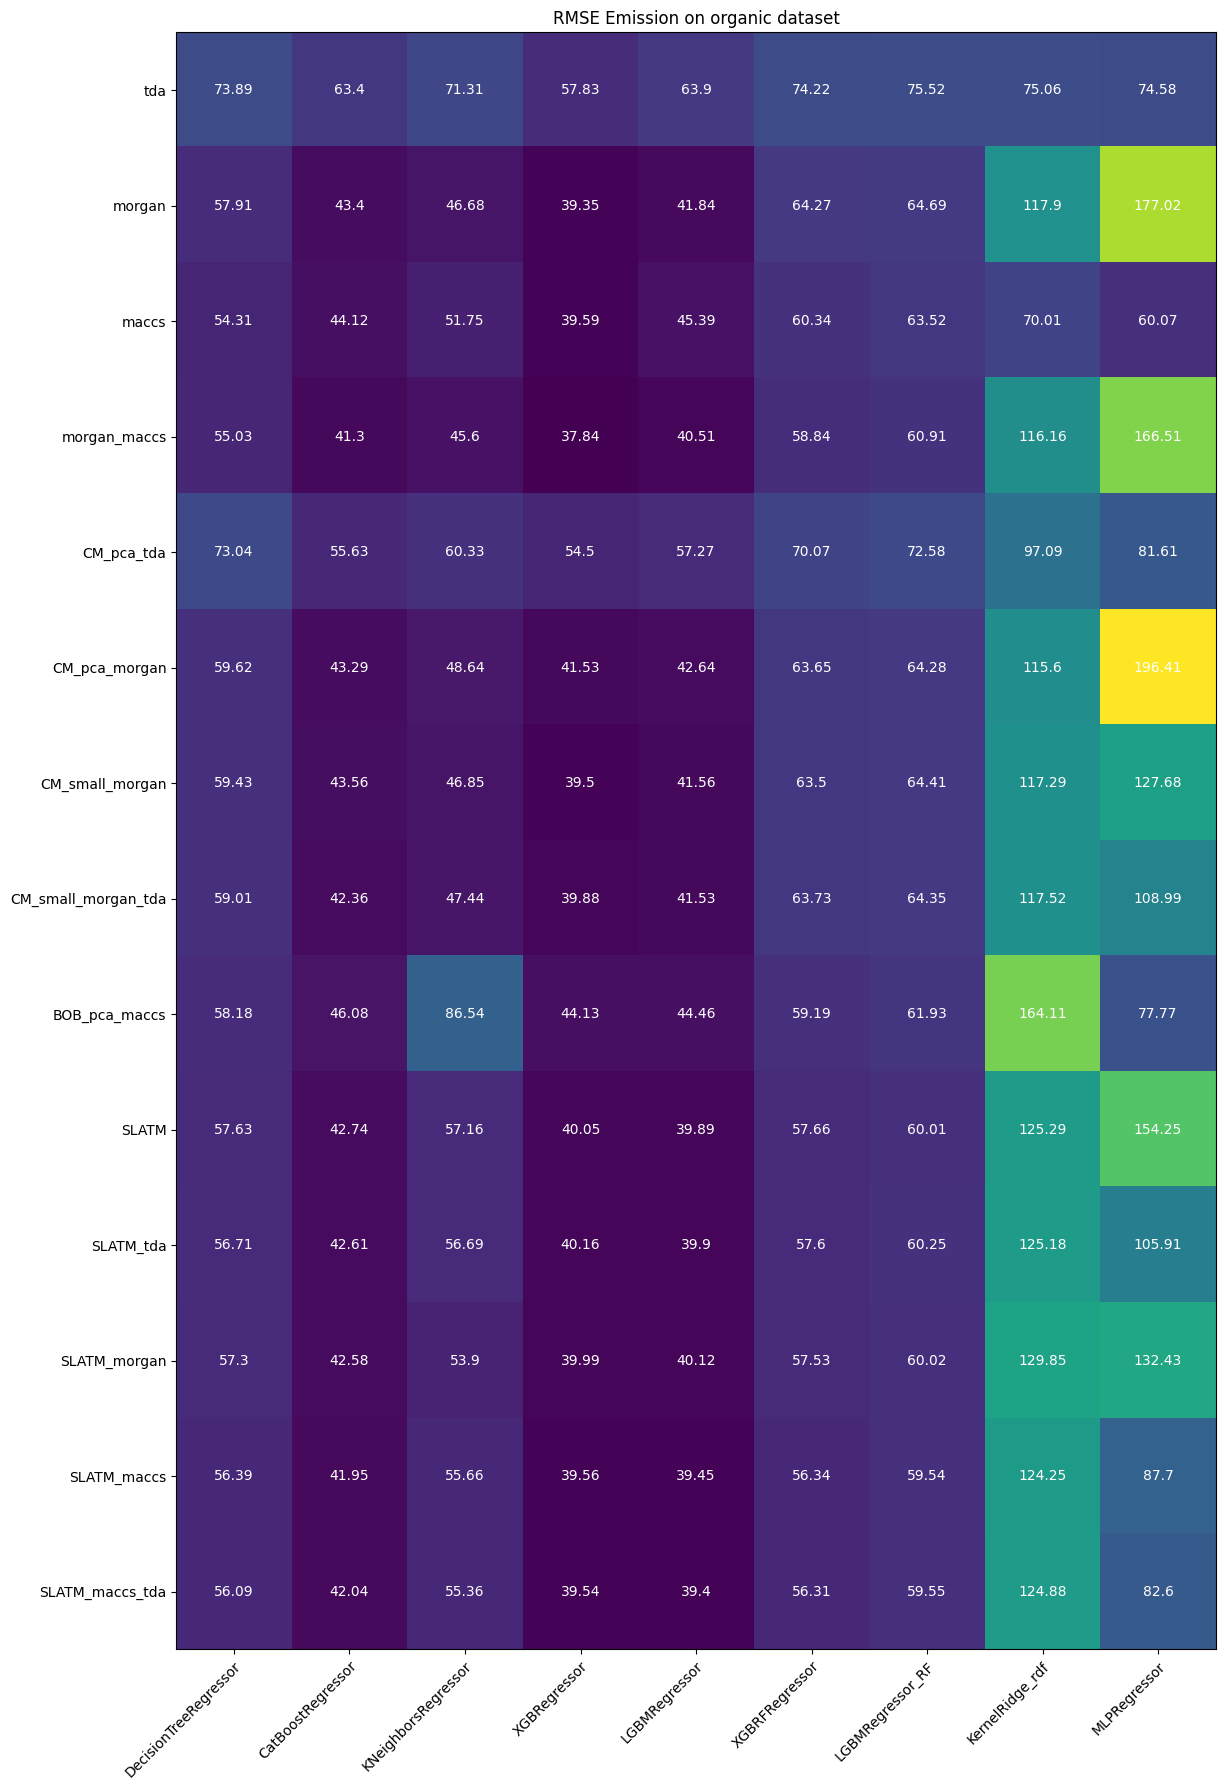

In [44]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(18, 18))
im = ax.imshow(result_df_em)
ax.set_xticks(np.arange(len(result_df_em.columns)), labels=result_df_em.columns)
ax.set_yticks(np.arange(len(result_df_em.index)), labels=result_df_em.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
for i in range(len(result_df_em.index)):
    for j in range(len(result_df_em.columns)):
        text = ax.text(j, i, round(np.array(result_df_em)[i, j],2),
                       ha="center", va="center", color="w")
ax.set_title("RMSE Emission on organic dataset")
fig.tight_layout()
plt.show()

#Quantumm yield

In [ ]:
BOB_pca_maccs_db_y =  pd.concat([BOB_pca, maccs_full, pd.DataFrame({'Quantumm':change_y}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_db_y = pd.concat([SLATM_full, pd.DataFrame({'Quantumm':change_y}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_tda_db_y= pd.concat([SLATM_full, tda_full, pd.DataFrame({'Quantumm':change_y}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
#SLATM_morgan_db_y = pd.concat([SLATM_full, morgan_full, pd.DataFrame({'Quantumm':change_y}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
#SLATM_maccs_db_y = pd.concat([SLATM_full, maccs_full, pd.DataFrame({'Quantumm':change_y}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()
SLATM_maccs_tda_db_y = pd.concat([SLATM_full, maccs_full, tda_full, pd.DataFrame({'Quantumm':change_y}),pd.DataFrame(start_db['Molecular weight (g mol-1)'])], axis=1).drop(['Unnamed: 0'],axis=1).drop_duplicates()

In [ ]:
list_of_dataset_y = [SLATM_db_y,SLATM_tda_db_y, SLATM_maccs_tda_db_y]

In [ ]:
list_of_dataset_y_name= ['SLATM', 'SLATM_tda', 'SLATM_maccs_tda']

In [ ]:
zero = np.zeros((len(list_of_dataset_y_name),len(model_name)))
result_df_y = pd.DataFrame(zero, columns = model_name, index = list_of_dataset_y_name)
result_df_y

,DecisionTreeRegressor,CatBoostRegressor,KNeighborsRegressor,XGBRegressor,LGBMRegressor,XGBRFRegressor,LGBMRegressor_RF,KernelRidge_rdf,VotingRegressor,MLPRegressor,KernelRidge_lin
SLATM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SLATM_tda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SLATM_maccs_tda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
models = [dt,  cat, knn,  xgb, lgbm,  xgb_rf, lgbm_rf]
model_name = ['DecisionTreeRegressor',
 'CatBoostRegressor',
 'KNeighborsRegressor',
 'XGBRegressor',
 'LGBMRegressor',
 'XGBRFRegressor',
 'LGBMRegressor_RF']

In [ ]:
from sklearn.preprocessing import StandardScaler



for i in range(len(list_of_dataset_y)):#len(list_of_dataset)):
    x_train, x_test, y_train, y_test = train_test_split(list_of_dataset_y[i].loc[:, list_of_dataset_y[i].columns != 'Quantumm'], list_of_dataset_y[i]['Quantumm'], test_size=0.2, random_state=42, shuffle=True)
    scaler = StandardScaler()
    x_train = x_train.fillna(0.0)
    scaler.fit(x_train)
    #y_train = np.log(y_train)
    #y_test = np.log(y_test)
    x_train = pd.DataFrame(scaler.transform(x_train))
    x_test = pd.DataFrame(scaler.transform(x_test))
    print('Scalling finished')
    for j in range(len(models)):#dt,  cat, knn,  xgb, lgbm,  xgb_rf, krr, voting_hard, MLP, krr_lin]:

        scores = cross_val_score(models[j], x_train, y_train, cv=KFold(n_splits=5, shuffle=True, random_state=rng), scoring='neg_root_mean_squared_error')
        #scores_mse_dict[f'{model_name[j].__class__.__name__}'] = -1*scores.mean()
        result_df_y[f'{model_name[j]}'][f'{list(list_of_dataset_y_name)[i]}'] = -1*scores.mean()
        result_df_y.to_csv('/content/drive/MyDrive/Y_CV.csv')
        print(f'{model_name[j]} MSE: {-1*scores.mean()}')

Выходные данные были обрезаны до нескольких последних строк (5000).
6:	learn: 0.2458424	total: 1.97s	remaining: 4m 39s
7:	learn: 0.2451306	total: 2.23s	remaining: 4m 37s
8:	learn: 0.2442861	total: 2.51s	remaining: 4m 36s
9:	learn: 0.2436151	total: 2.77s	remaining: 4m 34s
10:	learn: 0.2427466	total: 3.05s	remaining: 4m 34s
11:	learn: 0.2418847	total: 3.32s	remaining: 4m 33s
12:	learn: 0.2411513	total: 3.59s	remaining: 4m 32s
13:	learn: 0.2405660	total: 3.85s	remaining: 4m 31s
14:	learn: 0.2397430	total: 4.14s	remaining: 4m 31s
15:	learn: 0.2393078	total: 4.4s	remaining: 4m 30s
16:	learn: 0.2385831	total: 4.68s	remaining: 4m 30s
17:	learn: 0.2379988	total: 4.95s	remaining: 4m 30s
18:	learn: 0.2374161	total: 5.23s	remaining: 4m 29s
19:	learn: 0.2370325	total: 5.5s	remaining: 4m 29s
20:	learn: 0.2364073	total: 5.76s	remaining: 4m 28s
21:	learn: 0.2360471	total: 6.02s	remaining: 4m 27s
22:	learn: 0.2356450	total: 6.3s	remaining: 4m 27s
23:	learn: 0.2351738	total: 6.56s	remaining: 4m 26s
24:

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [09:28:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Выходные данные были обрезаны до нескольких последних строк (5000).
92:	learn: 0.2157206	total: 25s	remaining: 4m 3s
93:	learn: 0.2155600	total: 25.2s	remaining: 4m 3s
94:	learn: 0.2154038	total: 25.5s	remaining: 4m 2s
95:	learn: 0.2153199	total: 25.7s	remaining: 4m 2s
96:	learn: 0.2151634	total: 26s	remaining: 4m 2s
97:	learn: 0.2148700	total: 26.3s	remaining: 4m 1s
98:	learn: 0.2146666	total: 26.6s	remaining: 4m 1s
99:	learn: 0.2144550	total: 26.8s	remaining: 4m 1s
100:	learn: 0.2142535	total: 27.1s	remaining: 4m 1s
101:	learn: 0.2139345	total: 27.4s	remaining: 4m
102:	learn: 0.2138171	total: 27.6s	remaining: 4m
103:	learn: 0.2136279	total: 27.9s	remaining: 4m
104:	learn: 0.2135260	total: 28.2s	remaining: 3m 59s
105:	learn: 0.2134246	total: 28.4s	remaining: 3m 59s
106:	learn: 0.2131785	total: 28.7s	remaining: 3m 59s
107:	learn: 0.2129525	total: 29s	remaining: 3m 59s
108:	learn: 0.2127839	total: 29.2s	remaining: 3m 58s
109:	learn: 0.2126589	total: 29.5s	remaining: 3m 58s
110:	learn: 0